In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# Preuzimanje podataka od 2000 godine do 2025
ticker_symbol = 'AAPL'
start_date = '2000-01-01'
end_date = '2025-01-01'

df = yf.download(ticker_symbol, start=start_date, end=end_date, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.describe(include='all')

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,6289.000000,6289.000000,6289.000000,6289.000000,6.289000e+03
mean,41.146756,41.550611,40.700553,41.113521,3.859200e+08
std,60.016905,60.578397,59.379443,59.950525,3.837346e+08
min,0.196932,0.197983,0.190928,0.194980,2.323470e+07
25%,2.010148,2.039266,1.966918,2.011047,1.156272e+08
50%,13.795296,13.937940,13.682555,13.827337,2.677388e+08
75%,44.066647,44.409245,43.735839,44.031206,5.182408e+08
max,258.103729,259.179926,256.718662,257.276679,7.421641e+09


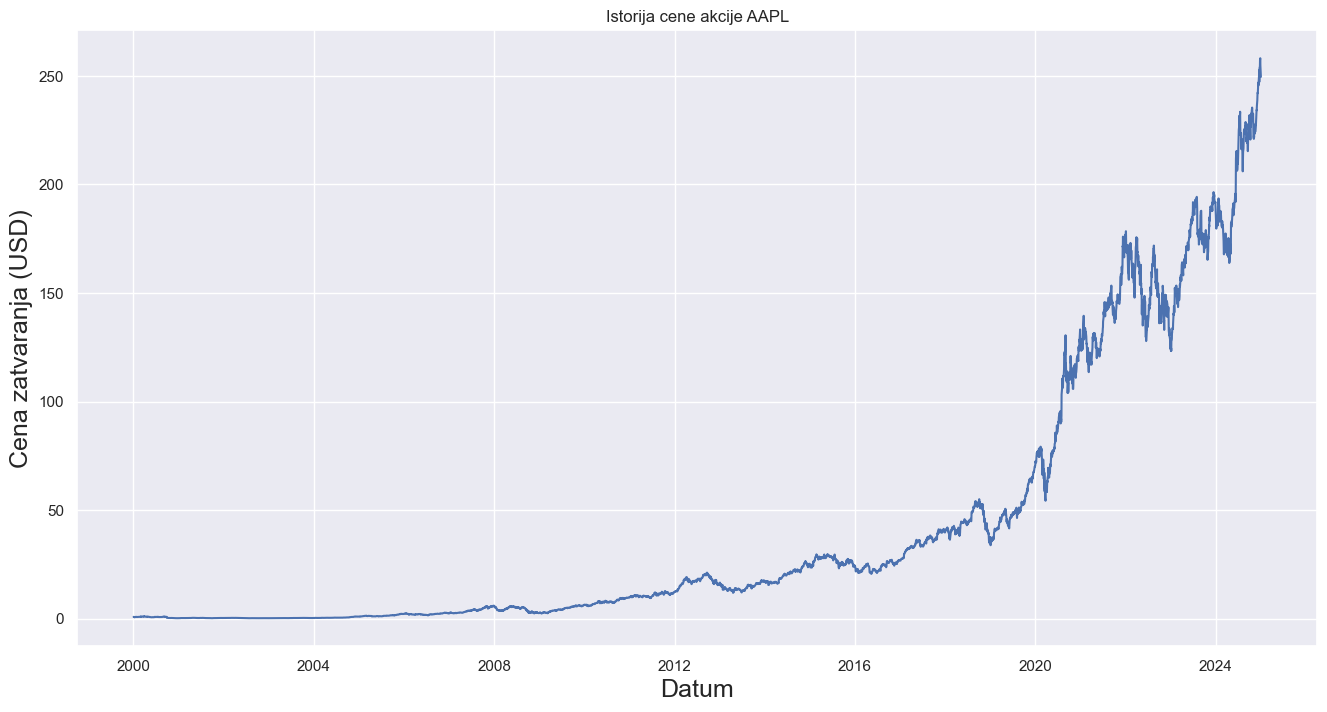

In [4]:
# Izdvajanje kolonu 'Close'
close_data = df.filter(['Close'])

# Vizuelizacija istorijskih podataka o ceni zatvaranja
plt.figure(figsize=(16,8))
plt.title(f'Istorija cene akcije {ticker_symbol}')
plt.plot(df['Close'])
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Cena zatvaranja (USD)', fontsize=18)
plt.show()

Korelaciona matrica:
Price             Close      High       Low      Open    Volume
Ticker             AAPL      AAPL      AAPL      AAPL      AAPL
Price  Ticker                                                  
Close  AAPL    1.000000  0.999936  0.999936  0.999863 -0.462498
High   AAPL    0.999936  1.000000  0.999916  0.999937 -0.462101
Low    AAPL    0.999936  0.999916  1.000000  0.999936 -0.462928
Open   AAPL    0.999863  0.999937  0.999936  1.000000 -0.462448
Volume AAPL   -0.462498 -0.462101 -0.462928 -0.462448  1.000000




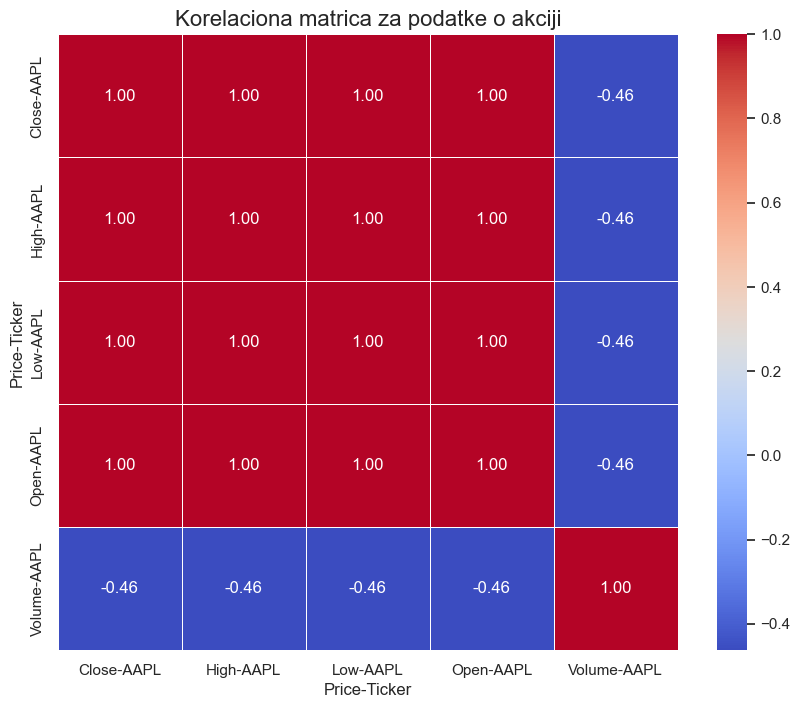

In [5]:
# --- KORAK ZA ANALIZU KORELACIJE ---

# Izračunavanje korelacione matrice za sve kolone u DataFrame-u
correlation_matrix = df.corr()

# Prikazivanje matrice
print("Korelaciona matrica:")
print(correlation_matrix)
print("\n")

# Kreiranje vizuelizacije - heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korelaciona matrica za podatke o akciji', fontsize=16)
plt.show()

In [6]:
# Kako sve kolone imaju jako visuku korelaciju sa close cenom jedino ima smisla ukljucivanje Volume-a
# Dodatno je pokusana izrada sa samo close cenom ili sa kombinacijama drugih kolona ali u krajnji rezultati tih testova bili nedovoljno dobri
# Osnovna ideja je definicija period na osnovu kog predviđamo sledeci dan tj u ovom slucaju na osnovu zadnja dva meseca predvidjamo danasnji dan
prediction_days = 60 

In [7]:
# --- KORAK 1: Izdvajanje CILJNIH KOLONA i podela na skupove ---

# Biramo 'Close' i 'Volume' kolone.
features = ['Close', 'Volume']
data = df[features]

# Pretvaramo u numpy niz
dataset = data.values

# Određujemo tačku podele (80% za trening i 20% za test)
training_data_len = int(np.ceil(len(dataset) * .8))

# Delimo podatke na trening i test skupove na osnovu ovih test podataka cemo videti koliko je dobar nas model
train_data = dataset[0:training_data_len, :]
test_data = dataset[training_data_len: , :]

In [8]:
# --- KORAK 2: Skaliranje podataka ---

#Kreiramo scaler kako dalja obrada podataka nije potrebna jer nemaju neke greske tj vrednosti koje nedostaju ili anomalije
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitujemo skaler na trening podacima.
scaled_train_data = scaler.fit_transform(train_data)

# Transformišemo test podatke koristeći naučene parametre
scaled_test_data = scaler.transform(test_data)

In [9]:
# --- KORAK 3: Kreiranje sekvenci za TRENING skup ---
x_train = []
y_train = []

for i in range(prediction_days, len(scaled_train_data)):
    # x_train dobija 60 prethodnih parova [Close, Volume]
    x_train.append(scaled_train_data[i-prediction_days:i, :])
    
    # y_train dobija 61. 'Close' cenu. Ona je na indeksu 0.
    y_train.append(scaled_train_data[i, 0])

# Konvertovanje u numpy nizove
x_train, y_train = np.array(x_train), np.array(y_train)

print(f"Dimenzije trening skupa x_train: {x_train.shape}")
print(f"Dimenzije trening skupa y_train: {y_train.shape}")

Dimenzije trening skupa x_train: (4972, 60, 2)
Dimenzije trening skupa y_train: (4972,)


In [10]:
# --- KORAK 4: Kreiranje sekvenci za TEST skup ---

# Kreiramo testni skup. Prvo uzimamo stvarne vrednosti za y_test.
y_test = test_data[prediction_days:, :] # Počinjemo od 61. dana test skupa

# Sada kreiramo x_test. Za svaku vrednost u y_test, treba nam 60 prethodnih dana.
x_test = []

for i in range(len(test_data) - prediction_days):
    # Izdvajamo sekvencu od 60 dana
    x_test.append(scaled_test_data[i:i+prediction_days, :])

# Konvertovanje u numpy niz
x_test = np.array(x_test)

print(f"Dimenzije test skupa x_test: {x_test.shape}")
print(f"Dimenzije test skupa y_test: {y_test.shape}")

Dimenzije test skupa x_test: (1197, 60, 2)
Dimenzije test skupa y_test: (1197, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout 

# --- KORAK 5: Definisanje arhitekture LSTM modela ---

# Inicijalizacija Sequential modela
model = Sequential()

# 2. Dodajemo eksplicitan Input sloj koji definiše oblik ulaznih podataka tj 60 dana close cena i volume-a
model.add(Input(shape=(x_train.shape[1], 2)))

# 3. Dodajemo prvi LSTM sloj
model.add(LSTM(units=224, return_sequences=True))

# 4. Dropout kolona deaktivira 10% neurona sto se pokazalo dobro u testiranju
model.add(Dropout(0.1))

# 5. Dodajemo drugi LSTM i dropout sloj
model.add(LSTM(units=224, return_sequences=False))
model.add(Dropout(0.1))

# 6. Dense sloj ima samo jedan unit kako trazimo jedan output tj cenu sledeceg dana
model.add(Dense(units=1))

# 7. Definisemo optimizer koji je najbolji ispao Adam sa learning rate-om 0.001
optimised_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# --- KORAK 6: Kompajliranje modela ---
model.compile(optimizer=optimised_optimizer, loss='mean_squared_error')

# Prikaz arhitekture modela i broja parametara
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 224)        │       203,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 224)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 224)            │       402,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,921 (2.31 MB)

 Trainable params: 605,921 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# --- KORAK 7: Treniranje modela sa VALIDACIJOM i RANIM ZAUSTAVLJANJEM ---

# Definišemo pravila za rano zaustavljanje kako ne zelimo overfitovan model
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience= 6,
    restore_best_weights=True
)

# Pokrećemo treniranje sa callback-om
start_time = time.time()
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping_callback]
)

end_time = time.time()
training_duration = end_time - start_time
minutes = int(training_duration // 60)
seconds = int(training_duration % 60)

print(f"\nTrening je završen (ili rano zaustavljen) za {minutes} minuta i {seconds} sekundi.")

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0038 - val_loss: 7.2817e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.4106e-05 - val_loss: 8.1236e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.0845e-04 - val_loss: 0.0012
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.8454e-05 - val_loss: 5.5629e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.0696e-05 - val_loss: 0.0012
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.2045e-05 - val_loss: 7.5408e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.0764e-05 - val_loss: 9.2567e-04
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 9.9775e-05 - val_loss: 5.0502e-04
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 7.0023e-05 - val_loss: 4.9236e-04
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 5.9683e-05 - val_loss: 0.0015

Trening je završen (ili rano zaustavljen) za 1 minuta

In [13]:
## PRVI BUILD MODEL KORISCEN ZA BAZICNO TUNE-OVANJE SVIH PARAMETARA

# import tensorflow as tf
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # --- KORAK 5: Definisanje funkcije za izgradnju modela (za KerasTuner) ---

# def build_model(hp):
#     model = Sequential()
    
#     model.add(Input(shape=(x_train.shape[1], 2)))
    
#     # 1. Tjuniranje broja neurona (jedinica) u LSTM slojevima
#     hp_units = hp.Int('units', min_value=128, max_value=256, step=32)
    
#     # 2. Tjuniranje stope za Dropout
#     hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)

#     model.add(LSTM(units=hp_units, return_sequences=True))
#     model.add(Dropout(rate=hp_dropout))
#     model.add(LSTM(units=hp_units, return_sequences=False))
#     model.add(Dropout(rate=hp_dropout))
#     model.add(Dense(units=1))

#     # 3. Tjuniranje stope učenja (learning rate) za Adam optimizator
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#         loss='mean_squared_error'
#     )
    
#     return model

In [14]:
## PRVI TUNER KORISCEN ZA BAZICNO TUNE-OVANJE SVIH PARAMETARA

# # --- KORAK 6: Inicijalizacija Tuner-a ---

# # Koristićemo RandomSearch, koji nasumično isprobava kombinacije.
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='keras_tuner_dir',
#     project_name='stock_prediction'
# )

# # Prikaz informacija o pretrazi
# tuner.search_space_summary()

In [15]:
## DRUGI BUILD MODEL KORISCEN ZA TUNE-OVANJE BROJA NEURONA KAKO SE POKAZALO DA JE MXKSIMUM PRETHODNE LIMITACIJE BIO IZABRAN

# import tensorflow as tf
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# def build_model_v2(hp):
#     model = Sequential()
#     model.add(Input(shape=(x_train.shape[1], 2)))
    
#     # 1. Tjuniranje broja neurona u NOVOM, VIŠEM opsegu
#     hp_units = hp.Int('units', min_value=128, max_value=256, step=32)
    
#     fixed_dropout = 0.1
#     fixed_learning_rate = 0.001

#     model.add(LSTM(units=hp_units, return_sequences=True))
#     model.add(Dropout(rate=fixed_dropout))
#     model.add(LSTM(units=hp_units, return_sequences=False))
#     model.add(Dropout(rate=fixed_dropout))
#     model.add(Dense(units=1))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=fixed_learning_rate),
#         loss='mean_squared_error'
#     )
    
#     return model

In [16]:
## DRUGI TUNER KORISCEN ZA TUNE-OVANJE BROJA NEURONA

# # --- KORAK 6 (Runda 2): Inicijalizacija Tuner-a za novu pretragu ---

# tuner_v2 = kt.RandomSearch(
#     build_model_v2,
#     objective='val_loss',
#     max_trials=5,
#     executions_per_trial=2,
#     directory='keras_tuner_dir',
#     project_name='stock_prediction_v2_units' 
# )

# tuner_v2.search_space_summary()

In [17]:
# POKRETANJE PRETRAGE HIPERPARAMETARA

# # --- KORAK 7: Pokretanje pretrage hiperparametara ---

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0001,
#     patience=5,
#     restore_best_weights=True
# )

# print("\n--- Započinjem pretragu hiperparametara ---")

# # tuner je za prvu fazu a tuner_v2 za drugu

# # tuner.search(
# #     x_train,
# #     y_train,
# #     epochs=50, # Dovoljno epoha da svaka proba pokaže svoj potencijal
# #     validation_split=0.2, # Koristimo veći split za pouzdaniju validaciju
# #     callbacks=[early_stopping_callback]
# # )

# tuner_v2.search(
#     x_train,
#     y_train,
#     epochs=50, # Dovoljno epoha da svaka proba pokaže svoj potencijal
#     validation_split=0.2, # Koristimo veći split za pouzdaniju validaciju
#     callbacks=[early_stopping_callback]
# )

# print("\n--- Pretraga završena! ---")

# # best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_hps_v2 = tuner_v2.get_best_hyperparameters(num_trials=1)[0]

# # print(f"""
# # Najbolji pronađeni hiperparametri:
# # - Broj jedinica (units): {best_hps.get('units')}
# # - Stopa dropout-a: {best_hps.get('dropout'):.2f}
# # - Stopa učenja (learning rate): {best_hps.get('learning_rate')}
# # """)
# print(f"""
# Rezultati druge runde pretrage:
# - Najbolji broj jedinica (units): {best_hps_v2.get('units')}
# - (Dropout je bio fiksiran na 0.10)
# - (Learning rate je bio fiksiran na 0.001)
# """)

# best_model = tuner_v2.get_best_models(num_models=1)[0]

# # Ponovno treniraj najbolji model na svim trening podacima
# print("\n--- Treniram finalni model sa najboljim hiperparametrima ---")
# history = best_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping_callback], validation_split=0.1)

# model = best_model

In [18]:
# --- KORAK 8: Pravljenje predviđanja na test podacima ---

predictions_scaled = model.predict(x_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
# --- KORAK 9: Vraćanje predviđanja na originalnu skalu ---

temp_array = np.zeros((len(predictions_scaled), 2))
temp_array[:, 0] = predictions_scaled.flatten()

predictions = scaler.inverse_transform(temp_array)
predictions_unscaled = predictions[:, 0]

Provera dimenzija nakon poravnanja:
Dimenzije y_test_aligned (stvarne vrednosti): (1197,)
Dimenzije predictions_unscaled (predviđene vrednosti): (1197,)

Evaluacija modela na test podacima:
Root Mean Squared Error (RMSE): $14.45


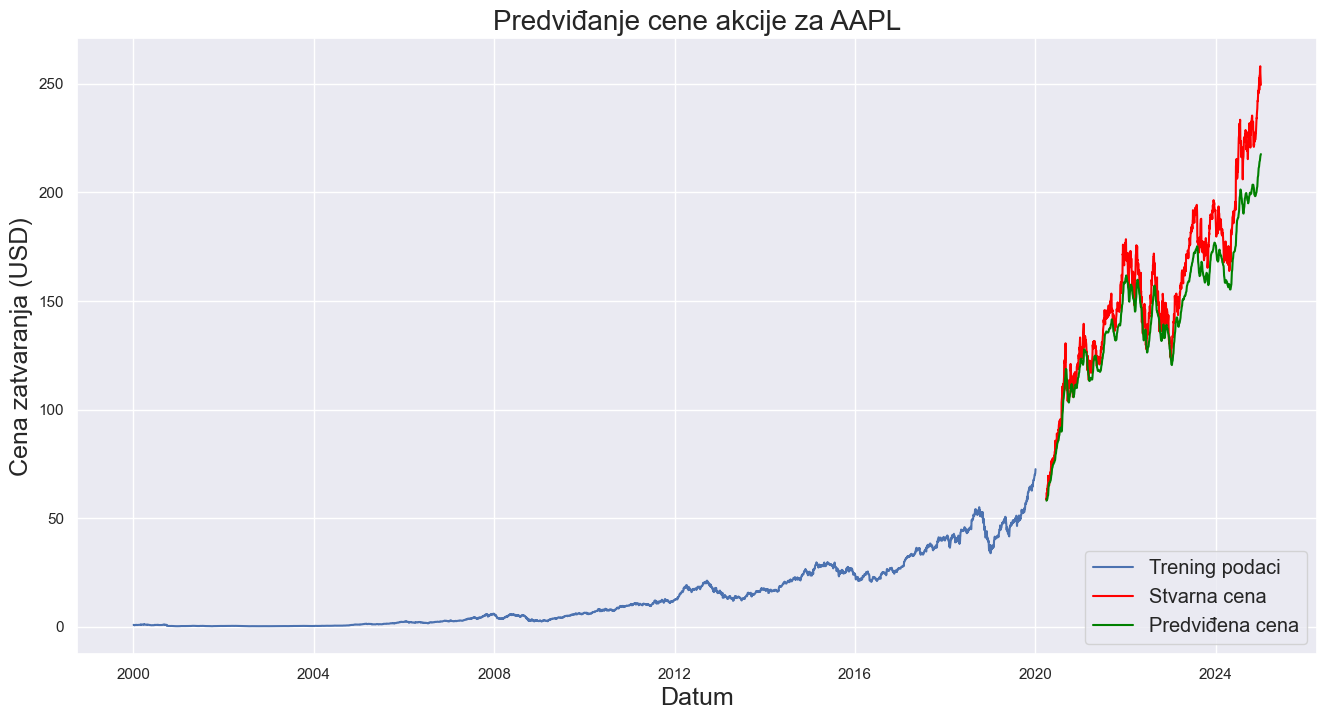


Poslednjih nekoliko stvarnih i predviđenih cena:
Price           Actual Predictions Percentage_Difference
Ticker            AAPL                                  
Date                                                    
2024-12-24  257.286682  215.222036            -16.349329
2024-12-26  258.103729  215.988036            -16.317352
2024-12-27  254.685867  216.812522            -14.870611
2024-12-30  251.307877  217.400475            -13.492375
2024-12-31  249.534180  217.633628            -12.784041


In [ ]:
from sklearn.metrics import mean_squared_error

# --- KORAK 10: Evaluacija modela - računanje RMSE ---

# Preskačemo prvih 'prediction_days' (60) vrednosti jer za njih nemamo predikciju.
y_test_aligned = dataset[training_data_len + prediction_days:, 0]

print("Provera dimenzija nakon poravnanja:")
print(f"Dimenzije y_test_aligned (stvarne vrednosti): {y_test_aligned.shape}")
print(f"Dimenzije predictions_unscaled (predviđene vrednosti): {predictions_unscaled.shape}")

rmse = np.sqrt(mean_squared_error(y_test_aligned, predictions_unscaled))

print(f"\nEvaluacija modela na test podacima:")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")


# --- KORAK 11: Vizuelizacija rezultata ---
data_for_plot = df[['Close']]
train = data_for_plot[:training_data_len]

valid_start_index = training_data_len + prediction_days
valid = data_for_plot[valid_start_index:].copy()

valid['Predictions'] = predictions_unscaled
valid.rename(columns={'Close': 'Actual'}, inplace=True)

# Izračunavanje procentualne razlike za svaki dan
# Formula: ((Predviđeno - Stvarno) / Stvarno) * 100
actual_values = valid['Actual'].values.flatten()
prediction_values = valid['Predictions'].values.flatten()

valid['Percentage_Difference'] = ((prediction_values - actual_values) / actual_values) * 100

plt.figure(figsize=(16,8))
plt.title(f'Predviđanje cene akcije za {ticker_symbol}', fontsize=20)
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Cena zatvaranja (USD)', fontsize=18)

plt.plot(train['Close'], label='Trening podaci')
plt.plot(valid['Actual'], color='red', label='Stvarna cena')
plt.plot(valid['Predictions'], color='green', label='Predviđena cena')

plt.legend(loc='lower right', fontsize='large')
plt.show()

# Prikaz poslednjih nekoliko predviđanja
print("\nPoslednjih nekoliko stvarnih i predviđenih cena:")
print(
    valid.tail().to_string(
        formatters={'Percentage_Difference': '{:.2f}%'.format}
    )
)